In [13]:
!uv add Pillow
!uv add matplotlib
!uv add sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 159 packages in 16ms
Audited 46 packages in 16ms
Resolved 159 packages in 3ms
Audited 46 packages in 1ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


⠙ pandas==2.3.3                                                                 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 160 packages in 748ms                                       
⠹ Preparing packages... (0/1)                                                   
⠹ Preparing packages... (0/1)--------------------     0 B/476.57 KiB         
⠹ Preparing packages... (0/1)-------------------- 16.00 KiB/476.57 KiB       
⠹ Preparing packages... (0/1)-------------------- 32.00 KiB/476.57 KiB       
⠹ Preparing packages... (0/1)-------------------- 48.00 KiB/476.57 KiB       
⠹ Preparing packages... (0/1)-------------------- 60.10 KiB/476.57 KiB       
⠹ Preparing packages... (0/1)-------------------- 76.10 KiB/476.57 KiB       
⠹ Preparing packages... (0/1)-------------------- 92.10 KiB/476.57 KiB       
⠹ Preparing packages... (0/1)-------------------- 108.10 KiB/476.57 KiB      
⠹ Preparing packages... (0/1)-------------------- 124.10 KiB/476.57 KiB      
⠹ Preparing packages... (0/1)-------------------- 140.10 KiB/476.57 KiB      
⠹ Preparing packages... (0/1)-------------------- 156.10 KiB/476.57 K

In [3]:
from urllib.request import urlopen
from PIL import Image

# 加载一张小狗在雪地里玩耍的AI生成的图像
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"

In [4]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# 加载分词器来预处理文本
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
# 加载预处理器来预处理图像
clip_processor = CLIPProcessor.from_pretrained(model_id)
# 用于生成文本嵌入和图像嵌入的主模型
model = CLIPModel.from_pretrained(model_id)

/Users/ohmycloud/opt/learning/llm/hands-on-large-language-model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 对输入进行分词
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
# 将输入转换为词元
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [7]:
# 创建文本嵌入
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [8]:
# 预处理图像
processed_image = clip_processor(
    text=None, images=image, return_tensors="pt"
)["pixel_values"]
processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

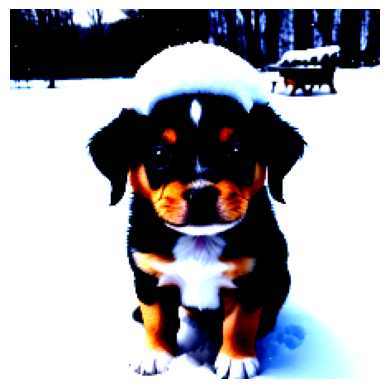

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 准备图像以进行可视化
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)

# 可视化预处理后的图像
plt.imshow(img)
plt.axis("off")

In [11]:
# 创建图像嵌入
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [12]:
# 对嵌入向量进化归一化处理
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# 计算它们的相似度
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()

score = np.dot(text_embedding, image_embedding.T)
score

array([[0.33149627]], dtype=float32)

In [15]:
from sentence_transformers import SentenceTransformer, util
from urllib.request import urlopen
from PIL import Image

# 加载一张小狗在雪地里玩耍的AI生成的图像
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"

images = [Image.open(urlopen(img_path)).convert("RGB") for img_path in [puppy_path, cat_path, car_path]]
captions = ["a puppy playing in the snow", "A pixelated image of a cute cat", "A supercar on the road with the sunset in the background"]

# 加载兼容SBERT的CLIP模型
model = SentenceTransformer("clip-ViT-B-32")
# 对图像进行编码
image_embeddings = model.encode(images)
# 对描述文本进行编码
text_embeddings = model.encode(captions)
# 计算余弦相似度
sim_matrix = util.cos_sim(
    image_embeddings, text_embeddings
)
sim_matrix


tensor([[0.3315, 0.1863, 0.1084],
        [0.1488, 0.3463, 0.0947],
        [0.0762, 0.1260, 0.3098]])

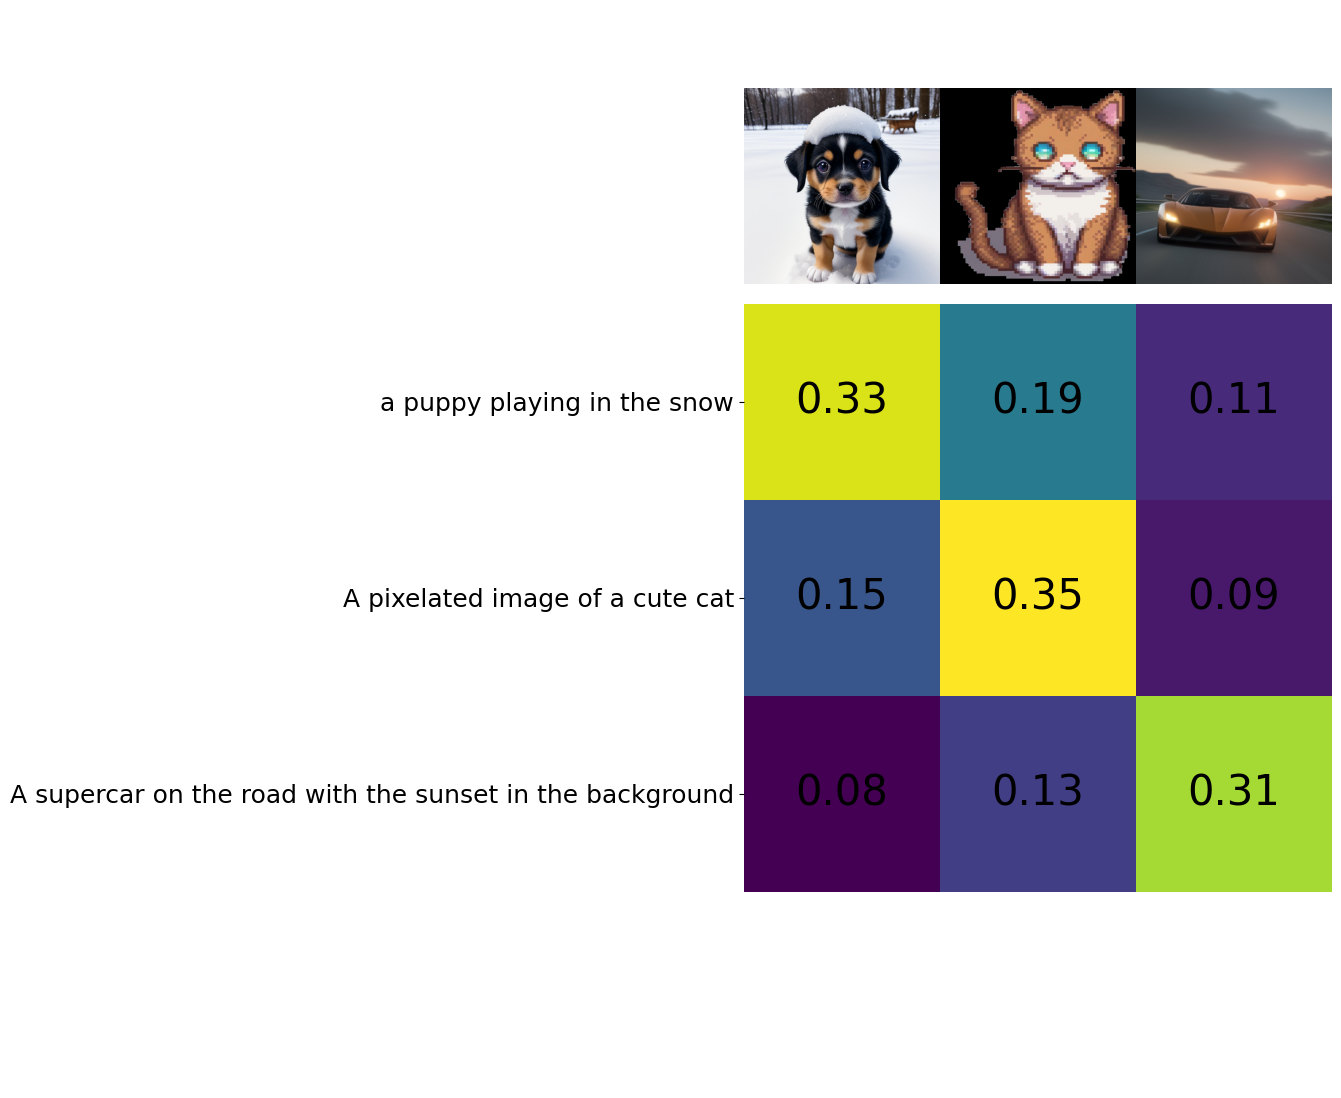

In [17]:
# create base figure
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

# resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')